In [7]:
import gym
gym.__version__
# 0.26.2

'0.26.2'

In [8]:
# Imports
import random
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [9]:
class PrioritizedReplayBuffer:
    def __init__(self, buffer_size, alpha=0.6, beta=0.4):
        self.alpha = alpha
        self.beta = beta
        self.buffer_size = buffer_size
        self.buffer = []
        self.position = 0
        self.priorities = np.zeros((buffer_size,), dtype=np.float32)

    def add(self, state, action, reward, state_, done):
        max_prio = self.priorities.max() if self.buffer else 1.0

        if len(self.buffer) < self.buffer_size:
            self.buffer.append((state, action, reward, state_, done))
        else:
            self.buffer[self.position] = (state, action, reward, state_, done)
        
        self.priorities[self.position] = max_prio
        self.position = (self.position + 1) % self.buffer_size

    def sample(self, batch_size):
        if len(self.buffer) == self.buffer_size:
            prios = self.priorities
        else:
            prios = self.priorities[:self.position]
        
        probs = prios ** self.alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-self.beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)
        
        batch = list(zip(*samples))
        states = torch.tensor(np.array(batch[0]), dtype=torch.float32)
        actions = torch.tensor(np.array(batch[1]), dtype=torch.int64)
        rewards = torch.tensor(np.array(batch[2]), dtype=torch.float32)
        states_ = torch.tensor(np.array(batch[3]), dtype=torch.float32)
        dones = torch.tensor(np.array(batch[4]), dtype=torch.int64)
        return states, actions, rewards, states_, dones, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, pi in zip(batch_indices, batch_priorities):
            self.priorities[idx] = pi

    def __len__(self):
        return len(self.buffer)


In [10]:
# Neural Network and Agent Classes

# Define a neural network class that inherits from the PyTorch nn.Module class.
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQNetwork, self).__init__()

        # Define the neural network layers and activation functions.
        self.fc1 = nn.Linear(input_dims[0], 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n_actions)

        # Define the optimizer and loss function for training the neural network.
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    # Define the forward pass of the neural network.
    def forward(self, state):
        layer1 = torch.relu(self.fc1(state))
        layer2 = torch.relu(self.fc2(layer1))
        actions = self.fc3(layer2)

        return actions

# Define an agent class for training the neural network.
class Agent():
    def __init__(self, input_dims, n_actions, buffer_size=10000, lr=2e-4, gamma=0.95,
                epsilon=1.0, eps_dec=5e-5, eps_min=0.01):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.action_space = [a for a in range(self.n_actions)]

        # Create instances of the neural networks for the agent.
        self.Q_network = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)
        self.Target_network = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

        # Create Priority Replay Buffer
        self.priority_replay_buffer = PrioritizedReplayBuffer(buffer_size)

    # Update the target network initially to match the online network.
    def update_target_network(self):
        self.Target_network.load_state_dict(self.Q_network.state_dict())


    # Define a function for choosing an action given an observation.
    def choose_action(self, state):
        if np.random.random() > self.epsilon:
            # Use the neural network to predict the Q-values for the current state.
            state = torch.tensor(state, dtype=torch.float).to(self.Q_network.device)
            actions = self.Q_network.forward(state)
            # Choose the action with the highest Q-value.
            action = torch.argmax(actions).item()
        else:
            # Choose a random action with probability epsilon.
            action = np.random.choice(self.action_space)

        return action

    # Define a function for decrementing epsilon over time to decrease exploration.
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    # Define a function for training the neural network with a batch of experiences.
    def learn(self, states, actions, rewards, states_, dones, indices, weights):
        self.Q_network.optimizer.zero_grad()
        # Convert the data to PyTorch tensors and move to the device for training.
        states = states.to(self.Q_network.device)
        actions = actions.to(self.Q_network.device)
        rewards = rewards.to(self.Q_network.device)
        states_ = states_.to(self.Target_network.device)
        dones = dones.to(self.Target_network.device)
        weights = torch.tensor(weights, dtype=torch.float32).to(self.Q_network.device)

        # Use the online network to predict the Q-values for the current states and select actions.
        q_pred = self.Q_network.forward(states).gather(1, actions.reshape(-1, 1))

        # Use the target network to predict the Q-values for the next states.
        q_next, _ = torch.max(self.Target_network.forward(states_), dim=1)

        # Calculate the target Q-values based on the current rewards and expected future rewards.
        q_target = rewards + self.gamma * (1-dones) * q_next
        q_target = q_target.detach()

        # Calculate the mean squared error loss between the predicted and target Q-values.
        loss  = (q_pred.squeeze() - q_target).pow(2) * weights
        pi = loss + 0.01
        loss = loss.mean()

        # Perform backpropagation to update the online network weights.
        loss.backward()
        self.Q_network.optimizer.step()

        self.priority_replay_buffer.update_priorities(indices, pi.data.cpu().numpy())

    def save(self, path):
        torch.save(self.Q_network.state_dict(), path)

    def load(self, path):
        self.Q_network.load_state_dict(torch.load(path))



In [11]:
# plot score and epsilon curves
def plot_score_epsilon(x_axis, scores, epsilons):
    fig, ax1 = plt.subplots()

    # Plot the first curve using the first y-axis.
    ax1.plot(x_axis, scores, 'b-', label='score')
    ax1.set_xlabel('x')
    ax1.set_ylabel('score', color='b')

    # Create a second y-axis object and plot the second curve using it.
    ax2 = ax1.twinx()
    ax2.plot(x_axis, epsilons, 'r-', label='epsilon')
    ax2.set_ylabel('epsilon', color='r')

    # Add a legend to the plot.
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower left')

    # Show the plot.
    plt.show()

state dim (8,)
action dim 4
episode 10, last score -150.3, avg score nan epsilon 0.97
episode 20, last score -177.3, avg score -150.3 epsilon 0.94
episode 30, last score -233.4, avg score -163.8 epsilon 0.91
episode 40, last score -118.3, avg score -187.0 epsilon 0.88
episode 50, last score -78.8, avg score -169.8 epsilon 0.85
episode 60, last score -83.9, avg score -151.6 epsilon 0.82
episode 70, last score -153.8, avg score -140.3 epsilon 0.79
episode 80, last score -112.4, avg score -142.2 epsilon 0.76
episode 90, last score -83.6, avg score -138.5 epsilon 0.73
episode 100, last score -94.8, avg score -132.4 epsilon 0.70
episode 110, last score -53.6, avg score -128.7 epsilon 0.67
episode 120, last score -28.9, avg score -119.0 epsilon 0.64
episode 130, last score -84.6, avg score -104.1 epsilon 0.61
episode 140, last score -155.4, avg score -89.3 epsilon 0.58
episode 150, last score -45.1, avg score -93.0 epsilon 0.55
episode 160, last score -89.8, avg score -89.6 epsilon 0.52
epis

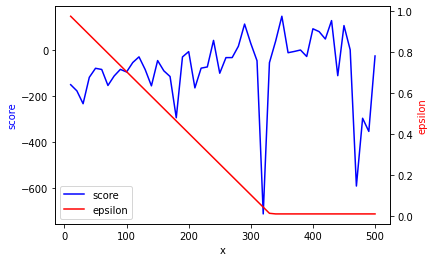

In [12]:
# Create the environment
env_name = 'LunarLander'
env = gym.make(env_name)

# Get the dimension of the state and action spaces
state_dim = env.reset()[0].shape
action_dim = env.action_space.n
print(f'state dim {state_dim}')
print(f'action dim {action_dim}')

# Define the path to save the trained model
save_path = 'models/'+env_name

# Define the number of episodes to run
n_episodes = 500
eps_decay = 3e-3

# Frequency at which to save the scores
save_score_freq = 10

# Number of episodes after which the target network is updated
target_update_freq = 2

# Initialize the replay buffer and define batch size
buffer_size = 10000
batch_size = 32

# Create an instance of the agent class
agent = Agent(input_dims=state_dim, n_actions=action_dim, buffer_size=buffer_size, eps_dec=eps_decay)

# Initialize tracking variables
end_all, x_axis, scores, epsilons = False, [], [], []
# Run the main training loop for the specified number of episodes
for i in range(n_episodes):
    # Reset the environment and initialize the score, done flag, and observation
    score = 0
    done = False
    state = env.reset()[0]
    steps = 0

    # Run the episode until the environment returns done
    while not done:
        # Choose an action based on the current observation and agent policy
        action = agent.choose_action(state)

        # Take a step in the environment and update the score, done flag, and observation
        state_, reward, done, info, _ = env.step(action)
        if steps>250:
            #end_all = True
            reward = -150
            done = True
            agent.priority_replay_buffer.add(state, action, reward, state_, done)  # Add the experience to the replay buffer
            break

        agent.priority_replay_buffer.add(state, action, reward, state_, done)  # Add the experience to the replay buffer

        # Perform learning if enough experiences are stored in the replay buffer
        if len(agent.priority_replay_buffer) > batch_size:
            states, actions, rewards, states_, dones, indices, weights = agent.priority_replay_buffer.sample(batch_size)  # Sample a batch of experiences
            agent.learn(states, actions, rewards, states_, dones, indices, weights)  # Train the agent with the sampled experiences

        state = state_
        score += reward
        steps += 1


    if i % target_update_freq == 0:
        agent.update_target_network()  # Update the target network weights periodically

    # Print the episode statistics and track the score and epsilon value over time
    if (i + 1) % save_score_freq == 0 or end_all:
        avg_score = np.mean(scores[-save_score_freq:])
        print(f'episode {i+1}, last score {score:.1f}, avg score {avg_score:.1f} epsilon {agent.epsilon:.2f}')
        x_axis.append(i+1)
        scores.append(score)
        epsilons.append(agent.epsilon)
        if end_all:
            break

    # Decrease the epsilon value to decrease exploration over time.
    agent.decrement_epsilon()

# Save the trained model
agent.save(save_path)  

# Plot the scores and epsilon values over time
plot_score_epsilon(x_axis, scores, epsilons)


In [13]:
#env_name = 'CartPole-v1'
env_name = 'LunarLander'
load_path = 'models/' + env_name

# Create an instance of the environment with rendering enabled.
env = gym.make(env_name, render_mode="human")

# Initialize and load the agent.
agent = Agent(input_dims=env.reset()[0].shape, n_actions=env.action_space.n)
agent.load(load_path)

# Set the exploration rate to zero to force the agent to choose actions based on its learned policy.
agent.epsilon = 0.0

# Reset the environment and obtain the initial state.
state = env.reset()[0]

# Run a single episode of the environment using the agent's learned policy.
done = False
n_episodes = 1
steps = 0
for _ in range(n_episodes):
    while not done:
        # Print the current observation and chosen action.
        print('---')
        print('State:', state)
        action = agent.choose_action(state)
        print('Action:', action)

        # Take a step in the environment and render the current state.
        state, reward, done, info, _ = env.step(action)
        env.render()
        steps += 1
        #time.sleep(0.1)  # Optional delay for visualization purposes.

    # Reset the environment and the done flag for the next episode.
    done = False
    env.reset(seed=42)
    print('STEPS: ', steps)
# Close the environment viewer.
env.close()


---
State: [-0.00670242  1.4175996  -0.6788991   0.29684272  0.00777323  0.15378077
  0.          0.        ]
Action: 3
---
State: [-0.013311    1.4237086  -0.6661419   0.27147397  0.012997    0.10448559
  0.          0.        ]
Action: 3
---
State: [-0.01984949  1.4292195  -0.65733135  0.24490005  0.01644735  0.0690133
  0.          0.        ]
Action: 3
---
State: [-0.02629728  1.4341416  -0.64595944  0.21875529  0.01761208  0.02329676
  0.          0.        ]
Action: 3
---
State: [-0.03264704  1.4384661  -0.6336639   0.19221163  0.01631049 -0.02603408
  0.          0.        ]
Action: 3
---
State: [-0.03892183  1.442204   -0.62425804  0.16616407  0.01312113 -0.06379329
  0.          0.        ]
Action: 3
---
State: [-0.04513178  1.4453506  -0.61611784  0.13988404  0.00830077 -0.09641629
  0.          0.        ]
Action: 3
---
State: [-0.05126924  1.4479072  -0.60702217  0.11364373  0.00165928 -0.13284205
  0.          0.        ]
Action: 3
---
State: [-0.05733204  1.4498557  -0.59